# Import modules

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
from math import exp

# Initial parameters

In [2]:
# Population size
n = 1

# Default Time beginning (second)
t = 0

# Default trial duration (second)
duration = 1.00  # 

# Default Time resolution (second)
dt = 0.001  # 0.0001

# Period occuring 
n_period = int(duration // dt) + 1

In [3]:
connections = ["GpeMsn", "FsiGpe", "MsnFsi"] #"MsnMsn", "FsiFsi", "GpeGpe"]
structures = ["Msn", "Fsi", "Gpe"]

h = {
    "Msn": -51.90,   # Mahon et al., 2006. RAT
    "Fsi": -47.30,   # Koos & Teper, 1999. RAT
    "Gpe": -55.10,   # Abdi, Mallet et al., 2015. RAT (In Vitro)

}

# Weights (connextions pre->post ; notation: PostPre)
G = {
    "GpeMsn": 1.00,
    "FsiGpe": 1.00,
    "MsnFsi": 1.00,
    #"MsnMsn": 1.00,
    #"FsiFsi": 1.00,
    #"GpeGpe": 1.00
}

# tau:
tau = {
    "GpeMsn": 0.0123,
    "FsiGpe": 0.0128,
    "MsnFsi": 0.0150,
    # "MsnMsn": 1.00,
    #"FsiFsi": 1.00,
   # "GpeGpe": 1.00
}

# Delays:
D = {
    "GpeMsn": 0.0070,
    "FsiGpe": 0.0010,
    "MsnFsi": 0.0044,
    #"MsnMsn": 1.00,
    #"FsiFsi": 1.00,
   # "GpeGpe": 1.00
}

# Initialization of the random generator (reproductibility !)
np.random.seed(1)

In [4]:
# creation of array of n neurons to store m, dm and connectivity probability(0 or 1)

m, dm, J = dict(), dict(), dict()

# J[con] = 1
for con in connections:   # created an array of 'nperiod' array(to store the value trought the time) with n zeroes
    m[con] = [[0 for x in range(n)] for y in range(n_period)]
    dm[con] = [[0 for x in range(n)] for y in range(n_period)]
    
    
for con in connections:
    if con  == 'GpeMsn':
        Co=1.00
    elif con == 'MsnFsi':
        Co=1.00
    elif con == 'FsiGpe':
        Co=1.00
    J[con] = np.reshape([[np.random.choice(2,n, p=[(1-Co),Co])] for y in range(n)],(n,n))
    print([con],J[con])

['GpeMsn'] [[1]]
['FsiGpe'] [[1]]
['MsnFsi'] [[1]]


In [5]:
# inputs
I = dict()
for stc in structures: # created an array of 'nperiod' array(to store the value trought the time) with n zeroes
    I[stc] = [[0 for x in range(n)] for y in range(n_period)]
    

In [6]:
input_mapping = {
    "Msn": "MsnFsi",
    "Gpe": "GpeMsn",
    "Fsi": "FsiGpe"
}

activities_mapping = {
    "GpeMsn": "Msn",
    "FsiGpe": "Gpe",
    "MsnFsi": "Fsi"

}

In [7]:
# Noise level (%)  = sigma from paper
N = {
    "Msn": 0.00,   
    "Fsi": 0.00,   
    "Gpe": 0.00
}

# Noise Function

In [8]:
# White Gaussian Noise
def WGnoise(size=1):
    n = np.random.normal(0, 1, size=size)
    return n


def noise(Z, level):  # Z = size of the population
    Z = (np.random.uniform(-level / 2, level / 2, Z)) * Z
    return Z


# Corrected Input function

In [9]:
# Function returning the corrected Input
def Ic(Input=0, threshold=0):
    if Input - threshold <= 0:
        return 0
    else:
        return (Input - threshold)
    

# Activity at time t-Delta (delay) function

In [10]:
# function to get the index "-delay/dt" in the list representing m(t-Delta)
def mdelta(synapse_value, delay, t, dt,i):
    if t < delay:  # if the delay is the time is too small, we take m(t-delta)=0
        return 0
    else:  # if the time is above or equal to the delay, we can find the m(t-delta)
        return synapse_value[int(-delay / dt)][i]
    

# - Simulation Core -

In [11]:
time_value = np.arange(0, duration, dt)

mDelta= dict()

for t in range(1, n_period):
    #for con in connections:
        
        #value[con][t] = m[con]  # command to add all activities of each population in a list respectively ; 
        # after each iteration

        #mDelta[con] = mdelta(value[con][:t + 1], D[con], time_value[t], dt)

        #m[con] += dm[con]  # we add the activity (dm) to the global activity (m),
            # after a step dt ; for all population
            # stored in the list ("PopulationNames"_value)

           # m[con][t]=[x+y for x, y in zip(m[con][t],dm[con][t])]
            #print
            
# ============================================Dynamic============================================================ 
    # noise_level = WGnoise(len(structures) + 2)
    
    for stc in structures:
        for i in range(n):
            if stc == "Msn" or "Gpe" or "Fsi":
                con = input_mapping[stc]
                #I[stc][t][i] = - G[con] * J[con] * (mdelta(m[con][:t + 1], D[con], time_value[t], dt,i)) + WGnoise()
                I[stc][t][i] = - sum([G[con] * x * (mdelta(m[con][:t + 1], D[con], time_value[t], dt,i)) for x in J[con][i]])
            else:
                pass
                #con = input_mapping[stc]
                #I[stc] = G[con] * J[con] * mDelta[con] + WGnoise()

    for con in connections:
        for i in range(n):
            # Update of activities
            stc = activities_mapping[con]
            dm[con][t][i] = dt * (- m[con][t][i] + Ic(I[stc][t][i], h[stc])) / tau[con] + float(noise(1, N[stc]))
        if t < n_period-1:
            m[con][t+1]=[x+y for x, y in zip(m[con][t],dm[con][t])]
        else:
            pass

# Plotting results

In [12]:
def plotting(k):
    valueGpeMsn=[0]*n_period
    valueFsiGpe=[0]*n_period
    valueMsnFsi=[0]*n_period
    for con in connections:
        for t in range(1,n_period):
        
            valueGpeMsn[t]=m['GpeMsn'][t][k]
            valueFsiGpe[t]=m['FsiGpe'][t][k]
            valueMsnFsi[t]=m['MsnFsi'][t][k]
        
    return plt.plot(time_value, valueGpeMsn, label='Msn'),plt.plot(time_value, valueFsiGpe, label='Gpe'),plt.plot(time_value, valueMsnFsi, label='Fsi'),plt.title('Activity over time: NEURON'+ str(k+1)),plt.ylabel('Activity'),plt.xlabel('time'),plt.grid(),plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.),plt.show()
    

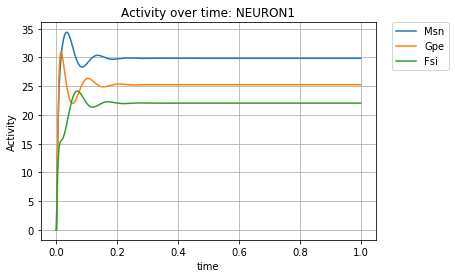

In [13]:
for k in range(0,n):
    plotting(k)

# Mean firing rate plotting

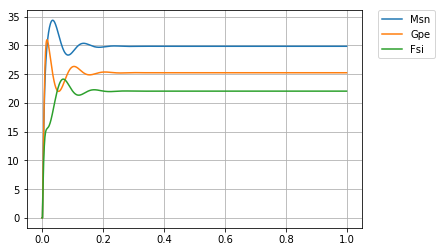

In [14]:
MeaniGM=list()
MeaniMF=list()
MeaniFG=list()
for con in connections:
    for t in range(0,n_period):
        if con  == 'GpeMsn':
            MeaniGM.append(np.mean(m['GpeMsn'][t]))
        elif con == 'MsnFsi':
            MeaniMF.append(np.mean(m['MsnFsi'][t]))
        elif con == 'FsiGpe':
            MeaniFG.append(np.mean(m['FsiGpe'][t]))  

plt.plot(time_value,MeaniGM,label='Msn')
plt.plot(time_value,MeaniFG,label='Gpe')
plt.plot(time_value,MeaniMF,label='Fsi')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.show()